In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess

os.environ['CUDA_VISIBLE_DEVICES']="1"


#from keras.layers import Dense, Input
#from keras.models import Model

#import omnifold6b as of

#import tensorflow as tf

#import simple_pdf2b as simple_pdf


In [2]:
print("\n\n")
print("  numpy version:  %s" % str(np.version.version) )
#print("  tensorflow version:  %s" % str(tf.__version__))
print("\n\n")




  numpy version:  1.26.4





## Set model and resolution parameters

In [3]:
ndim = 1

##-------------

train_mu = [ 0.0 ]



train_rho = [ [0.0] ]






train_sig = [ 1.0 ]


##-------------


true_mu = [ 0.2 ]






true_rho  = [ [0.0] ]



true_sig = [ 0.9 ]






#--- perfect
#resolution = [ 0.000001  ]

#--- very good
#resolution = [ 0.05  ]

#--- good
#resolution = [ 0.25  ]

#--- nominal
resolution = [ 0.5  ]

#--- medium poor
#resolution = [ 0.75  ]

#--- poor
#resolution = [ 1.0  ]







train_cov = np.zeros( shape=(ndim,ndim) )
true_cov  = np.zeros( shape=(ndim,ndim) )

print("\n\n\n Train covariance:")

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            train_cov[i][j] = train_sig[i] * train_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, train_cov[i][j]))
        else :
            k = ndim - j - 1
            train_cov[i][j] = train_sig[i] * train_sig[j] * train_rho[i][k]
            train_cov[j][i] = train_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, train_sig[i], train_sig[j], train_rho[i][k], train_cov[i][j]))
            
            

print("\n\n\n True covariance:")  

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            true_cov[i][j] = true_sig[i] * true_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, true_cov[i][j]))
        else :
            k = ndim - j - 1
            true_cov[i][j] = true_sig[i] * true_sig[j] * true_rho[i][k]
            true_cov[j][i] = true_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, true_sig[i], true_sig[j], true_rho[i][k], true_cov[i][j]))
            
            
                

                
                






ngen_train = 100000
ngen_true =   10000

#ngen_train = 1000000
#ngen_true =   100000

of_niter = 5





do_bootstrap = False

n_boot_samples = 500



ds_input_dir = 'bootstrap-toy-study8a-1d-1d-nominal-resolution'


output_dir = 'hist-pdf-toy-study-1d-1b-read-points'

#save_step2_model = True



hist_low = -10.
hist_high = 10.

hist_nbins = 1000


hist_binwidth = (hist_high - hist_low) / hist_nbins

window_dx = 0.3

window_nbins = int( window_dx / hist_binwidth )

print(' window_nbins : %d' % window_nbins)

hist_pars = {}
hist_pars['low']  = hist_low
hist_pars['high'] = hist_high
hist_pars['nbins'] = hist_nbins
hist_pars['binwidth'] = hist_binwidth
hist_pars['window_dx'] = window_dx
hist_pars['window_nbins'] = window_nbins






 Train covariance:
   0,  0 : diagonal    1.0000



 True covariance:
   0,  0 : diagonal    0.8100
 window_nbins : 15


In [4]:
hist_pars

{'low': -10.0,
 'high': 10.0,
 'nbins': 1000,
 'binwidth': 0.02,
 'window_dx': 0.3,
 'window_nbins': 15}

In [5]:
try:
    os.mkdir( output_dir )
except:
    print('\n\n Output directory already exists:  %s' % output_dir)
    #print('\n\n HALTING EXECUTION\n\n')
    #sys.exit()



 Output directory already exists:  hist-pdf-toy-study-1d-1b-read-points


In [6]:
print("\n\n")
print("Train covariance determinant:  %f" % np.linalg.det( train_cov ) )
print("True covariance determinant:   %f" % np.linalg.det( true_cov ) )
print("\n\n")




Train covariance determinant:  1.000000
True covariance determinant:   0.810000





In [7]:
train_cov_inv = np.linalg.inv( train_cov )

In [8]:
train_cov_inv_test = np.matmul( train_cov, train_cov_inv )

In [9]:
print("\n\n")
print(" Train covariance")
print( train_cov )
print("\n Train covariance inverse")
print( train_cov_inv )
print("\n Train covariance inverse test")
print(train_cov_inv_test)
print("\n\n")




 Train covariance
[[1.]]

 Train covariance inverse
[[1.]]

 Train covariance inverse test
[[1.]]





In [10]:
true_cov_inv = np.linalg.inv( true_cov )

In [11]:
true_cov_inv_test = np.matmul( true_cov, true_cov_inv )

In [12]:
print("\n\n")
print(" True covariance")
print( true_cov )
print("\n True covariance inverse")
print( true_cov_inv )
print("\n True covariance inverse test")
print(true_cov_inv_test)
print("\n\n")




 True covariance
[[0.81]]

 True covariance inverse
[[1.2345679]]

 True covariance inverse test
[[1.]]





## Generate samples, save events and config

In [13]:

#--- Read the datasets instead of generating new ones.

#train_pts = np.random.multivariate_normal(train_mu, train_cov, size=ngen_train)
#true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)

#train_det_pts = np.random.normal( train_pts, resolution )

#true_det_pts = np.random.normal( true_pts, resolution )



with open('%s/train-and-true-samples.npy' % ds_input_dir, 'rb') as f :
    train_pts = np.load(f)
    train_det_pts = np.load(f)
    true_pts = np.load(f)
    true_det_pts = np.load(f)

print('\n\n train_pts:')
print( train_pts )
print('\n\n')
print(' train_pts shape:  %s' % str(train_pts.shape))

train_both = np.stack([train_pts, train_det_pts], axis=1)
    
#-- ok to regenerate these (just for plots)
true_pts10x = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true*40)
true_det_pts10x = np.random.normal( true_pts10x, resolution )
true_pts10x_weights = np.ones( ngen_true*40 )
true_pts10x_weights = (1./40.) * true_pts10x_weights




 train_pts:
[[-0.46336226]
 [ 0.02393367]
 [-0.20724547]
 ...
 [ 1.12523375]
 [ 0.97045159]
 [-0.12846198]]



 train_pts shape:  (100000, 1)


In [14]:
with open( '%s/train-and-true-samples.npy' % output_dir, 'wb') as f :
    np.save(f, train_pts)
    np.save(f, train_det_pts)
    np.save(f, true_pts)
    np.save(f, true_det_pts)

In [15]:
with open( '%s/config-pars.npy' % output_dir , 'wb' ) as f :
    np.save( f, train_mu )
    np.save( f, train_rho )
    np.save( f, train_sig )
    np.save( f, true_mu )
    np.save( f, true_rho )
    np.save( f, true_sig )
    np.save( f, resolution )
    np.save( f, train_cov )
    np.save( f, true_cov )

In [16]:
config_filename = '%s/config.txt' % output_dir

config_file = open( config_filename, 'w' )

config_file.write('%s\n\n' % datetime.now() )
config_file.write('ngen_train %d\n' % ngen_train )
config_file.write('ngen_true  %d\n' % ngen_true )
config_file.write('of_niter   %d\n' % of_niter )
config_file.write('ndim       %d\n' % ndim )



config_file.write('\n\n')
config_file.write('train_mu : %s\n' % str(train_mu))
config_file.write('train_rho : %s\n' % str(train_rho))
config_file.write('train_sig : %s\n' % str(train_sig))
config_file.write('train_cov : %s\n' % str(train_cov))
config_file.write('\n\n')
config_file.write('true_mu : %s\n' % str(true_mu))
config_file.write('true_rho : %s\n' % str(true_rho))
config_file.write('true_sig : %s\n' % str(true_sig))
config_file.write('true_cov : %s\n' % str(true_cov))
config_file.write('\n\n')
config_file.write('resolution : %s\n' % str(resolution) )
config_file.close()

print('\n\n  Config file contents : %s\n' % config_filename )
print( subprocess.getoutput('cat %s' % config_filename ))
print('\n\n')





  Config file contents : hist-pdf-toy-study-1d-1b-read-points/config.txt

2024-07-11 08:34:50.112951

ngen_train 100000
ngen_true  10000
of_niter   5
ndim       1


train_mu : [0.0]
train_rho : [[0.0]]
train_sig : [1.0]
train_cov : [[1.]]


true_mu : [0.2]
true_rho : [[0.0]]
true_sig : [0.9]
true_cov : [[0.81]]


resolution : [0.5]





## Plots to visualize these parameter choices

<function matplotlib.pyplot.show(close=None, block=None)>

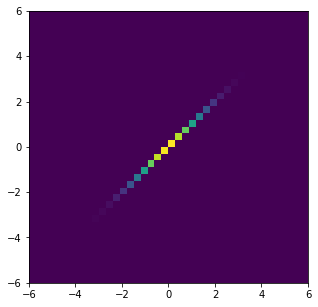

In [17]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if ndim > 1 :
            thisax = ax[i][j]
        else :
            thisax = ax
            
        thisax.hist2d( train_pts[:,i], train_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

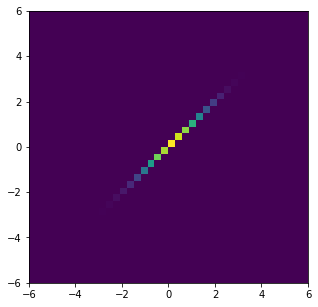

In [18]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if ndim > 1 :
            thisax = ax[i][j]
        else :
            thisax = ax
        thisax.hist2d( true_pts[:,i], true_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

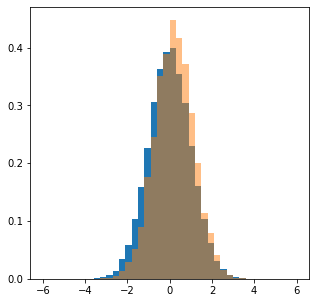

In [19]:
fig,ax = plt.subplots( 1, ndim, figsize=(ndim*5,5))

hmin=-6
hmax=6
hbins=40


for i in range(ndim) :
        k = i*3 + j
        if ndim > 1 :
            thisax = ax[i]
        else :
            thisax = ax
        thisax.hist( train_pts[:,i],bins=hbins, range=[hmin,hmax], density=True )
        thisax.hist( true_pts[:,i],bins=hbins, range=[hmin,hmax], density=True, alpha=0.5 )
    
plt.show

### Calculate true weights analytically and compare with unfolding output weights.

In [20]:
train_pts_minus_train_mu = train_pts - train_mu
print(train_pts_minus_train_mu)

[[-0.46336226]
 [ 0.02393367]
 [-0.20724547]
 ...
 [ 1.12523375]
 [ 0.97045159]
 [-0.12846198]]


In [21]:
train_pts_minus_true_mu = train_pts - true_mu
print(train_pts_minus_true_mu)

[[-0.66336226]
 [-0.17606633]
 [-0.40724547]
 ...
 [ 0.92523375]
 [ 0.77045159]
 [-0.32846198]]


In [22]:
true_cov_inv_times_v = np.tensordot( true_cov_inv, train_pts_minus_true_mu.T, axes=(1,0) )

In [23]:
v_times_true_cov_inv_times_v =  np.sum( train_pts_minus_true_mu.T * true_cov_inv_times_v, axis=0)

In [24]:
train_cov_inv_times_v = np.tensordot( train_cov_inv, train_pts_minus_train_mu.T, axes=(1,0) )

In [25]:
v_times_train_cov_inv_times_v =  np.sum( train_pts_minus_train_mu.T * train_cov_inv_times_v, axis=0)

In [26]:
exp_v_times_train_cov_inv_times_v = np.exp( -0.5 * v_times_train_cov_inv_times_v )
exp_v_times_true_cov_inv_times_v  = np.exp( -0.5 * v_times_true_cov_inv_times_v  )

In [27]:
true_cov_det = np.linalg.det( true_cov )
train_cov_det = np.linalg.det( train_cov )

In [28]:
norm2_true = np.power( 3.14159265, ndim) * true_cov_det
print("\n norm2_true : %f\n" % norm2_true )


 norm2_true : 2.544690



In [29]:
norm2_train = np.power( 3.14159265, ndim) * train_cov_det
print("\n norm2_train : %f\n" % norm2_train )


 norm2_train : 3.141593



In [30]:
pdf_train = exp_v_times_train_cov_inv_times_v / np.sqrt(norm2_train)
print(pdf_train)

[0.50676027 0.56402802 0.55220259 ... 0.29956003 0.35230673 0.55955347]


In [31]:
pdf_true = exp_v_times_true_cov_inv_times_v / np.sqrt(norm2_true)
print(pdf_true)

[0.47776327 0.61499581 0.56587602 ... 0.36956266 0.43455989 0.58648892]


In [32]:
pdf_ratio = pdf_true / pdf_train

In [33]:
sample_sf = (1.*len(true_pts))/(1.*len(train_pts))
print('\n sample_sf = %f' % sample_sf )


 sample_sf = 0.100000


In [34]:
calc_weight = pdf_ratio

In [35]:
calc_weight_scaled = sample_sf * pdf_ratio

In [36]:
with open( '%s/analytic-weights.npy' % output_dir, 'wb') as f :
    np.save(f, calc_weight_scaled)

## Define function for calculating model pars (mean and cov) from weighted events

In [37]:
def calc_mean_cov( weights, fi1, fi2, sample_points ) :

    return_dict = {}
    
    wsum = np.sum( weights )
    
    wx1 = np.sum( weights * sample_points[:,fi1] )
    wx2 = np.sum( weights * sample_points[:,fi2] )
    wx1x2 = np.sum( weights * sample_points[:,fi1] * sample_points[:,fi2] )

    x1 = wx1 / wsum
    x2 = wx2 / wsum

    x1x2 = wx1x2 / wsum
    
    cov12 = x1x2 - x1*x2

    
    return_dict["mean_x1"] = x1
    return_dict["mean_x2"] = x2
    return_dict["cov_x1x2"] = cov12    
    
    if fi1 != fi2 :
        wx1x1 = np.sum( weights * sample_points[:,fi1] * sample_points[:,fi1] )
        wx2x2 = np.sum( weights * sample_points[:,fi2] * sample_points[:,fi2] )
        cov11 = wx1x1 / wsum - x1*x1
        cov22 = wx2x2 / wsum - x2*x2

        rms1 = np.sqrt(cov11)
        rms2 = np.sqrt(cov22)
        rho12 = cov12 / (rms1*rms2)     
    
        return_dict["rho12"] = rho12
        return_dict["rms1"] = rms1
        return_dict["rms2"] = rms2
    else :
        rms1 = np.sqrt(cov12)
        return_dict["rms1"] = rms1
        
    return return_dict


    

In [38]:
weights_true = np.ones( ngen_true )

In [39]:
true_calc_mean = np.zeros( ndim )
true_calc_cov = np.ones( shape=(ndim,ndim) )

In [40]:
for fi1 in range(ndim) :
    for fi2 in range(fi1,ndim) :
        rd = calc_mean_cov( weights_true, fi1, fi2, true_pts )
        true_calc_mean[fi1] = rd['mean_x1']
        true_calc_cov[fi1,fi2] = rd['cov_x1x2']

In [41]:
for fi1 in range(ndim) :
    print('  mean f%d :  %7.3f' % (fi1, true_calc_mean[fi1]))
    for fi2 in range(fi1,ndim) :
        print('  cov f%df%d :  %7.4f' % (fi1,fi2, true_calc_cov[fi1,fi2]))
        if fi1 == fi2 :
            print('  sigma f%d :  %7.4f' % (fi1, np.sqrt(true_calc_cov[fi1,fi1])))
        

  mean f0 :    0.212
  cov f0f0 :   0.8272
  sigma f0 :   0.9095


In [42]:
print( true_pts.shape )
print( true_pts.shape[1])

(10000, 1)
1


In [43]:
def calc_model_pars( weights, sample_points, verbose=0 ) :
    
    return_dict = {}
    
    ndim = sample_points.shape[1]
    if verbose : print(' ndim = %d' % ndim )
    
    model_mean = np.zeros( ndim )
    model_cov = np.ones( shape=(ndim,ndim) )
    
    for fi1 in range(ndim) :
        for fi2 in range(fi1,ndim) :
            rd = calc_mean_cov( weights, fi1, fi2, sample_points )
            model_mean[fi1] = rd['mean_x1']
            model_cov[fi1,fi2] = rd['cov_x1x2']    
            if verbose and fi2==fi1 : print('  mean f%d :  %7.3f' % (fi1, model_mean[fi1]))
            if verbose : print('  cov f%df%d :  %7.4f' % (fi1,fi2, model_cov[fi1,fi2]))
            if verbose and fi2==fi1 : print('  sigma f%d :  %7.4f' % (fi1, np.sqrt(model_cov[fi1,fi1])))
   
    for fi2 in range(ndim) :
        for fi1 in range(fi2+1,ndim) :
            model_cov[fi1,fi2] = model_cov[fi2,fi1]
    
    return_dict['mean'] = model_mean
    return_dict['cov']  = model_cov
    
    return return_dict


In [44]:
test_calc_true_model = calc_model_pars( weights_true, true_pts, 1)

 ndim = 1
  mean f0 :    0.212
  cov f0f0 :   0.8272
  sigma f0 :   0.9095


In [45]:
test_calc_true_model

{'mean': array([0.2121073]), 'cov': array([[0.8272155]])}

## Define function to calculate the reweighting factor (pdf2/pdf1).

In [46]:
def calc_pdf_ratio( model1_mu, model2_mu, model1_cov, model2_cov, sample_points ) :
    
    ndim = len(model1_mu)
    
    pts_minus_mu1 = sample_points - model1_mu
    pts_minus_mu2 = sample_points - model2_mu
    
    cov1_inv = np.linalg.inv( model1_cov )
    cov2_inv = np.linalg.inv( model2_cov )
    
    cov1_det = np.linalg.det( model1_cov )
    cov2_det = np.linalg.det( model2_cov )
    
    cov1_inv_times_v1 = np.tensordot( cov1_inv, pts_minus_mu1.T, axes=(1,0) )
    cov2_inv_times_v2 = np.tensordot( cov2_inv, pts_minus_mu2.T, axes=(1,0) )
    
    v1_times_cov1_inv_times_v1 =  np.sum( pts_minus_mu1.T * cov1_inv_times_v1, axis=0)
    v2_times_cov2_inv_times_v2 =  np.sum( pts_minus_mu2.T * cov2_inv_times_v2, axis=0)
    
    exp_v1_times_cov1_inv_times_v1 = np.exp( -0.5 * v1_times_cov1_inv_times_v1 )
    exp_v2_times_cov2_inv_times_v2 = np.exp( -0.5 * v2_times_cov2_inv_times_v2 )
    
    norm2_model1 = np.power( 3.14159265, ndim) * cov1_det
    norm2_model2 = np.power( 3.14159265, ndim) * cov2_det
    
    pdf1 = exp_v1_times_cov1_inv_times_v1 / np.sqrt(norm2_model1)
    pdf2 = exp_v2_times_cov2_inv_times_v2 / np.sqrt(norm2_model2)
    
    pdf_ratio = pdf1 / pdf2
    
    return pdf_ratio
    
    

In [47]:
test_calc_pdf_ratio = calc_pdf_ratio( true_mu, train_mu, true_cov, train_cov, train_pts )

In [48]:
test_calc_pdf_ratio

array([0.94277966, 1.09036393, 1.02476161, ..., 1.2336848 , 1.23347031,
       1.04813739])

In [49]:
pdf_ratio

array([0.94277966, 1.09036393, 1.02476161, ..., 1.2336848 , 1.23347031,
       1.04813739])

## Function that estimates the pdf from a histogram (multi-bin sum)

In [50]:

#-- computes pdf2/pdf1 at location of points1
#
#    for OmniFold step 1, points2 is the data, points1 is the MC
#

def pdf_ratio_from_hist( points1, points2, weights1, weights2, hist_pars, verbose=0 ) :
    
    ndim = points1.shape[1]
    
    if ndim > 1 :
        print('\n\n *** Only 1D supported for now.\n\n')
        sys.exit()
        
    hist_low = hist_pars['low']
    hist_high = hist_pars['high']
    hist_nbins = hist_pars['nbins']
    hist_binwidth = hist_pars['binwidth']
    
    
    nph1 = np.histogram( points1[:,0], hist_nbins, range=[hist_low, hist_high], weights=weights1 )
    nph2 = np.histogram( points2[:,0], hist_nbins, range=[hist_low, hist_high], weights=weights2 )
    
    hist_pdf1 = np.zeros(hist_nbins)
    hist_pdf2 = np.zeros(hist_nbins)

    for bi in range( hist_nbins ) :
        bilow = bi - window_nbins
        bihigh = bi + window_nbins
        if bilow < 0 : bilow = 0
        if bihigh >= hist_nbins : bihigh = hist_nbins-1

        hist_pdf1[bi] = np.sum( nph1[0][bilow: bihigh] )
        hist_pdf2[bi] = np.sum( nph2[0][bilow: bihigh] )
    
    hist_pdf1_norm = hist_pdf1 / np.sum(hist_pdf1)
    hist_pdf2_norm = hist_pdf2 / np.sum(hist_pdf2)
    
    hist_bin_indices1 = np.array(   ( (points1[:,0] - hist_low) / hist_binwidth ),   dtype=int )
    
    points1_pdf1_val = hist_pdf1_norm[ hist_bin_indices1 ]
    points1_pdf2_val = hist_pdf2_norm[ hist_bin_indices1 ]
    
    points1_pdf1_val = np.clip( points1_pdf1_val, 1.e-10, 1.e10)
    points1_pdf2_val = np.clip( points1_pdf2_val, 1.e-10, 1.e10)
    
    pdf_ratio = points1_pdf2_val / points1_pdf1_val
    
    return pdf_ratio
    

In [51]:
print('pdf_ratio shape : %s' % str(pdf_ratio.shape))

pdf_ratio shape : (100000,)


In [52]:
weights_true = np.ones( ngen_true )
weights_train = np.ones( ngen_train )

print(' train_pts shape: %s' % str(train_pts.shape))
print('  true_pts shape: %s' % str(true_pts.shape))
print(' weights_train shape: %s' % str(weights_train.shape))
print('  weights_true shape: %s' % str(weights_true.shape))

test_hist_pdf_ratio = pdf_ratio_from_hist( train_pts, true_pts, weights_train, weights_true, hist_pars )

 train_pts shape: (100000, 1)
  true_pts shape: (10000, 1)
 weights_train shape: (100000,)
  weights_true shape: (10000,)


In [53]:
pdf_ratio

array([0.94277966, 1.09036393, 1.02476161, ..., 1.2336848 , 1.23347031,
       1.04813739])

In [54]:
calc_weight

array([0.94277966, 1.09036393, 1.02476161, ..., 1.2336848 , 1.23347031,
       1.04813739])

In [55]:
test_hist_pdf_ratio

array([0.93505882, 1.05997387, 0.99220197, ..., 1.23760074, 1.23072886,
       1.0064385 ])

In [56]:
test_hist_pdf_ratio.shape

(100000,)

In [57]:
for pi in range(40) :
    print( ' %3d   x %7.3f   true  %7.4f  from hist %7.4f' % (pi, train_pts[pi,0], calc_weight[pi], test_hist_pdf_ratio[pi]))

   0   x  -0.463   true   0.9428  from hist  0.9351
   1   x   0.024   true   1.0904  from hist  1.0600
   2   x  -0.207   true   1.0248  from hist  0.9922
   3   x   0.176   true   1.1281  from hist  1.0990
   4   x  -0.418   true   0.9580  from hist  0.9565
   5   x   0.259   true   1.1466  from hist  1.1298
   6   x  -0.158   true   1.0394  from hist  1.0011
   7   x  -0.980   true   0.7603  from hist  0.7556
   8   x  -0.337   true   0.9842  from hist  0.9664
   9   x  -1.158   true   0.6958  from hist  0.6914
  10   x   0.695   true   1.2161  from hist  1.1996
  11   x   0.670   true   1.2135  from hist  1.2020
  12   x   1.510   true   1.2045  from hist  1.1896
  13   x   0.350   true   1.1650  from hist  1.1514
  14   x  -1.155   true   0.6971  from hist  0.6914
  15   x   1.409   true   1.2162  from hist  1.2262
  16   x  -0.418   true   0.9580  from hist  0.9565
  17   x   0.990   true   1.2339  from hist  1.2219
  18   x  -0.016   true   1.0798  from hist  1.0478
  19   x   1

## Define OmniFold implementation with fit pdf

In [58]:
def hist_pdf_omnifold1a( theta0, theta_unknown_S, iterations, verbose=0 ) :
    
    weights = np.empty(shape=(iterations, 2, len(theta0)))
    # shape = (iteration, step, event)
    push_weights_for_output = np.empty(shape=(iterations, len(theta0)))

    theta0_G = theta0[:,0]
    theta0_S = theta0[:,1]

    ngen_train = len(theta0)
    ngen_true  = len(theta_unknown_S)
    ndim = theta0_G.shape[1]

    labels0 = np.zeros(len(theta0))
    labels_unknown = np.ones(len(theta_unknown_S))
    labels_unknown_step2 = np.ones(len(theta0_G))


    neval_train = ngen_train
    neval_true  = ngen_true


    if verbose :
        print("\n\n")
        print("  ======== simple_pdf2b\n\n")
        print("  shape of theta0_S : %s" % str(np.shape(theta0_S)) )
        print("  shape of theta0_G : %s" % str(np.shape(theta0_G)) )
        print("  shape of theta_unknown_S : %s" % str(np.shape(theta_unknown_S)) )
        print("\n  iterations = %d\n" % iterations )
        print("  ndim : %d" % ndim )
        print("  neval_train : %d" % neval_train )
        print("  neval_true  : %d" % neval_true )
        print("\n\n")

    # initial iterative weights are ones
    weights_pull = np.ones(len(theta0_S))
    weights_push = np.ones(len(theta0_S))


    sample_norm_sf = ( (1.*neval_train)/(1.*neval_true) ) *  ( (1.*ngen_true)/(1.*ngen_train) )
    
    
    if verbose :
        print('\n\n Calculating model pars for data or true (theta_unknown_S)')
        
    
    #model_pars_theta_unknown_S = calc_model_pars( np.ones( ngen_true ), theta_unknown_S, verbose )
    
    
    
    
    
    
    return_dict = {}
    
    for i in range(iterations):
    
        if (verbose>0):
            print("\nITERATION: {}\n".format(i + 1))
            
        if (verbose>0):
            print("   -- ITERATION %d  STEP 1\n" % (i+1) )
            
        print(" weights_push at the beginning")
        print( weights_push )

        
        #model_pars_theta0_S = calc_model_pars( weights_push, theta0_S, verbose )
        
        #pdf_ratio_step1 = calc_pdf_ratio( model_pars_theta_unknown_S['mean'],
        #                           model_pars_theta0_S['mean'],
        #                           model_pars_theta_unknown_S['cov'],
        #                           model_pars_theta0_S['cov'],
        #                           theta0_S )

        pdf_ratio_step1 = pdf_ratio_from_hist( theta0_S, 
                                              theta_unknown_S, 
                                              weights_push, 
                                              np.ones( ngen_true ),
                                              hist_pars
                                             )
        if verbose>0 :
            print(' pdf_ratio_step1:  shape %s ' % str(pdf_ratio_step1.shape))
            print(pdf_ratio_step1)
        
        
        step1_output_weights = sample_norm_sf * pdf_ratio_step1

        weights_pull = weights_push * step1_output_weights
        
        if verbose>0 :
            print("  iter %d, step1_output_weights:  shape %s" % (i+1, str(step1_output_weights.shape)))
            print(step1_output_weights)


        weights[i, :1, :] = step1_output_weights


            
            

        if (verbose>0):
            print("\n   -- ITERATION %d  STEP 2\n" % (i+1) )
            
        #if verbose : print(' calculation of model pars with push weights')
        #model_pars_theta0_G_push_weight = calc_model_pars( weights_push, theta0_G, verbose )

        #if verbose : print(' calculation of model pars with pull weights')
        #model_pars_theta0_G_pull_weight = calc_model_pars( weights_pull, theta0_G, verbose )
        
        #pdf_ratio_step2 = calc_pdf_ratio( model_pars_theta0_G_pull_weight['mean'],
        #                           model_pars_theta0_G_push_weight['mean'],
        #                           model_pars_theta0_G_pull_weight['cov'],
        #                           model_pars_theta0_G_push_weight['cov'],
        #                           theta0_G )        

        
        pdf_ratio_step2 = pdf_ratio_from_hist( theta0_G, 
                                              theta0_G, 
                                              weights_push, 
                                              weights_pull,
                                              hist_pars
                                             )
        
        
        step2_output_weights = pdf_ratio_step2
        
        weights_push = weights_push * step2_output_weights
        
        push_weights_for_output[i] = weights_push
        
        weights[i, 1:2, :] = step2_output_weights
        
        if verbose>0 :
           print("  iter %d, step2_output_weights:" % (i+1))
           print(step2_output_weights)
        
    return_dict["weights"] = weights

    return_dict["push_weights"] = push_weights_for_output

    return_dict["final_push_weights"] = weights_push

    return return_dict
            
            

In [59]:
rd = hist_pdf_omnifold1a( train_both, true_det_pts, of_niter, 1 )




  ======== simple_pdf2b


  shape of theta0_S : (100000, 1)
  shape of theta0_G : (100000, 1)
  shape of theta_unknown_S : (10000, 1)

  iterations = 5

  ndim : 1
  neval_train : 100000
  neval_true  : 10000





 Calculating model pars for data or true (theta_unknown_S)

ITERATION: 1

   -- ITERATION 1  STEP 1

 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 pdf_ratio_step1:  shape (100000,) 
[0.90570116 1.08911359 1.0247737  ... 1.20604915 1.22640817 0.99192166]
  iter 1, step1_output_weights:  shape (100000,)
[0.90570116 1.08911359 1.0247737  ... 1.20604915 1.22640817 0.99192166]

   -- ITERATION 1  STEP 2

  iter 1, step2_output_weights:
[0.94084032 1.05157251 1.00026729 ... 1.17452309 1.16822796 1.01817064]

ITERATION: 2

   -- ITERATION 2  STEP 1

 weights_push at the beginning
[0.94084032 1.05157251 1.00026729 ... 1.17452309 1.16822796 1.01817064]
 pdf_ratio_step1:  shape (100000,) 
[0.96831232 1.04450825 1.01467256 ... 1.05185014 1.07168582 1.00505843]
  iter 2, ste

In [60]:
of_weights = rd["weights"]

mc_weight_sf = (1.*len(true_det_pts))/(1.*len(train_both))

push_weights = rd["push_weights"]
push_weights_scaled = np.copy( push_weights )
push_weights_scaled = mc_weight_sf * push_weights

final_push_weights = rd["final_push_weights"]
final_push_weights_scaled = np.copy(final_push_weights)
final_push_weights_scaled = mc_weight_sf * final_push_weights

with open( '%s/omnifold-output-weights.npy' % output_dir, 'wb') as f :
    np.save(f, final_push_weights_scaled)


<function matplotlib.pyplot.show(close=None, block=None)>

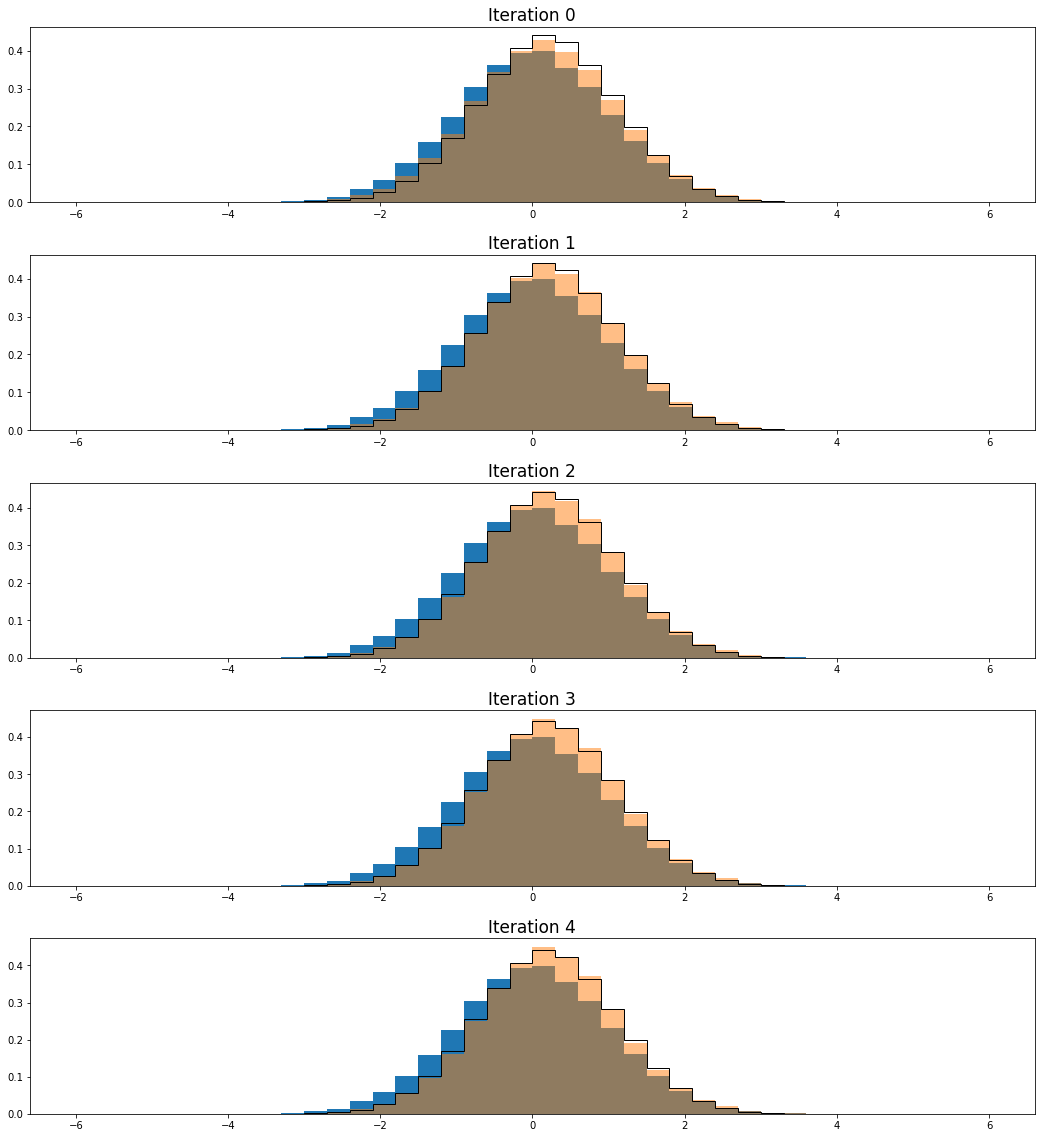

In [61]:


fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
            
            thisax.hist( train_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )            
            hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :
        
        for di in range(ndim) :

            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
                
            hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )            
            hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
#    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
#    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
 
    if ndim > 1 :
        thisax = ax[ofi][0]
    else :
        thisax = ax[ofi]
        
    thisax.set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [62]:
hist_data_diff = hist_data_mc_ofweighted - hist_data_truth
hist_data_diff2 = hist_data_diff * hist_data_diff

hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        hist_data_sum_diff2[ofi,di] = np.sum( hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

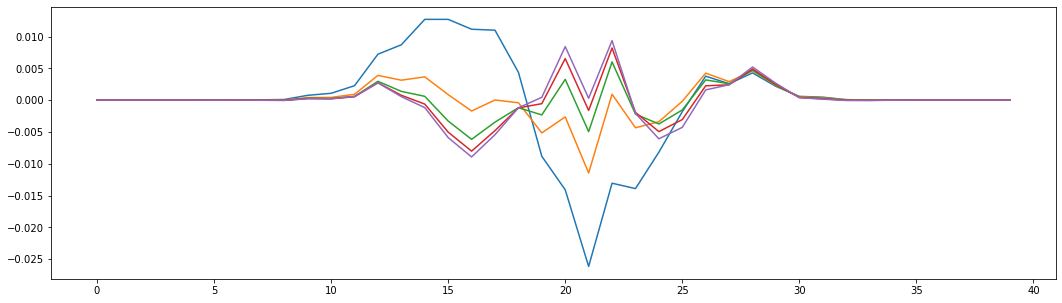

In [63]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim > 1 :
            thisax = ax[di]
        else :
            thisax = ax
        thisax.plot(hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

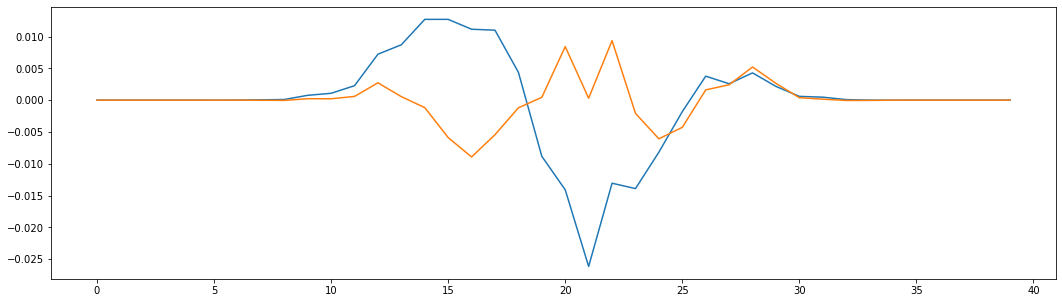

In [64]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(hist_data_diff[ofi,di])
    
plt.show 

<function matplotlib.pyplot.show(close=None, block=None)>

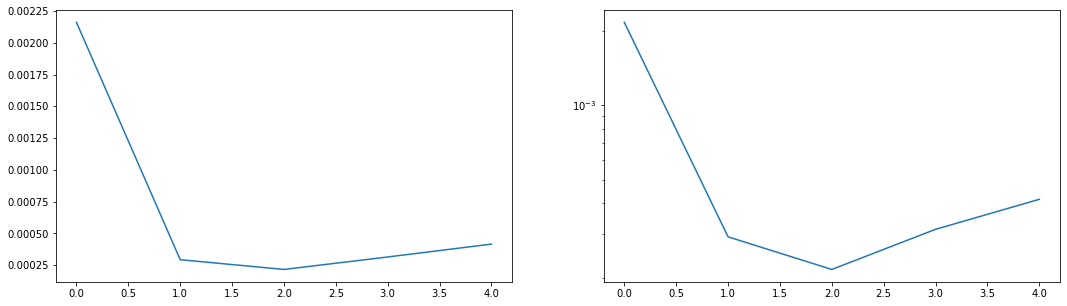

In [65]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( hist_data_sum_diff2)
ax[1].plot( hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

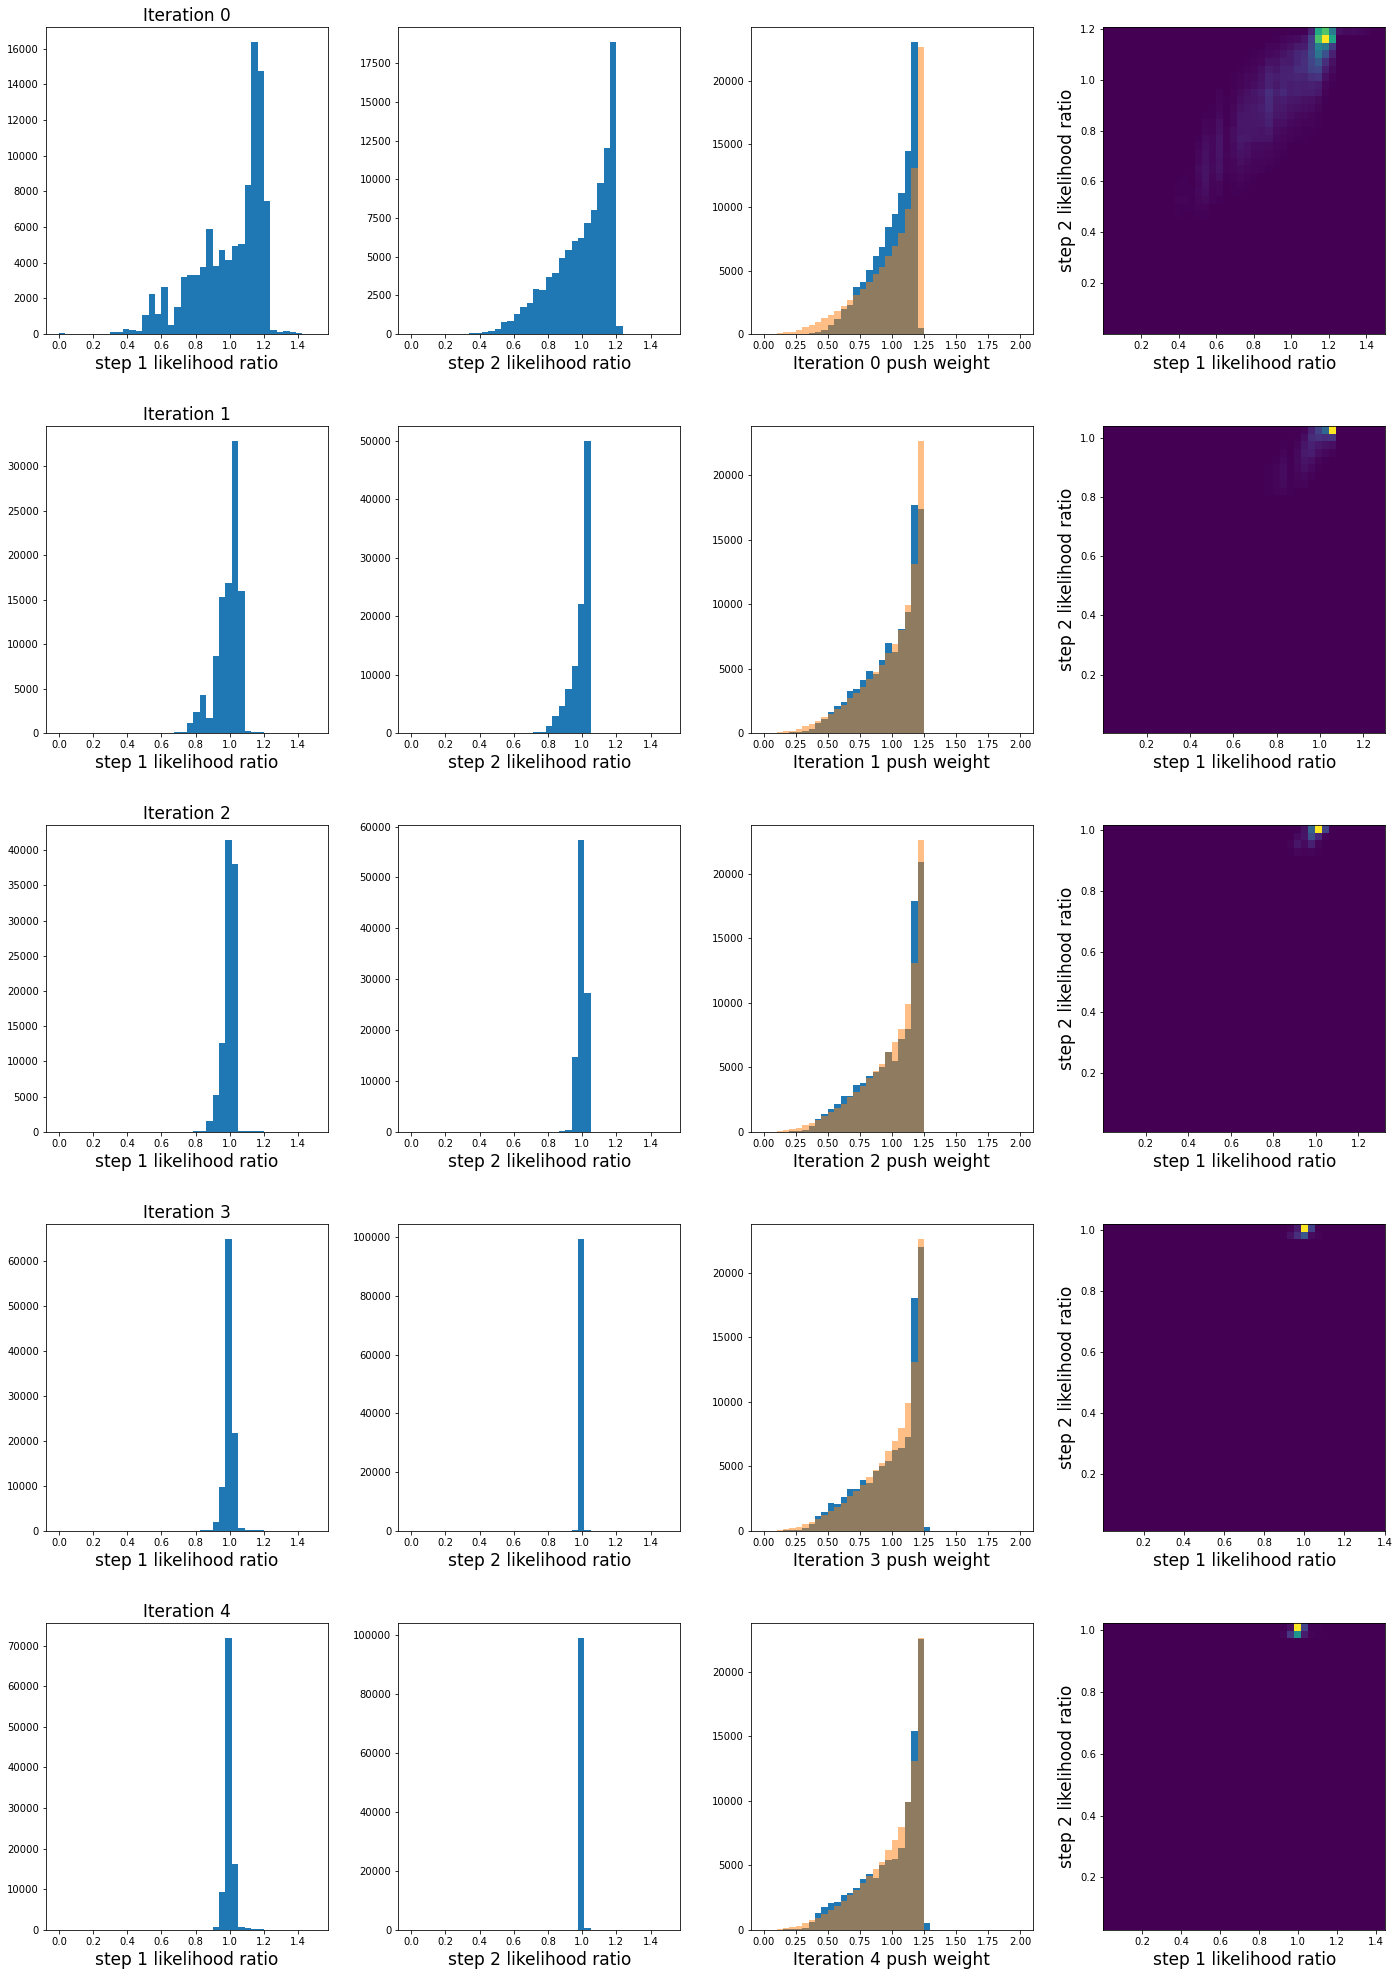

In [66]:
fig,ax = plt.subplots( of_niter, 4, figsize=(24,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist( of_weights[ofi,0,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][1].hist( of_weights[ofi,1,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][2].hist( push_weights[ofi,:], bins=hbins, range=[0.,2.0] )
    ax[ofi][2].hist( calc_weight, bins=hbins, range=[0.,2.0], alpha=0.5 )
    
    
    ax[ofi][3].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins] )
    
    ax[ofi][0].set_xlabel( 'step 1 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'step 2 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][3].set_xlabel( 'step 1 likelihood ratio', fontsize=lfontsize )
    ax[ofi][3].set_ylabel( 'step 2 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][2].set_xlabel( 'Iteration %d push weight' % ofi, fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

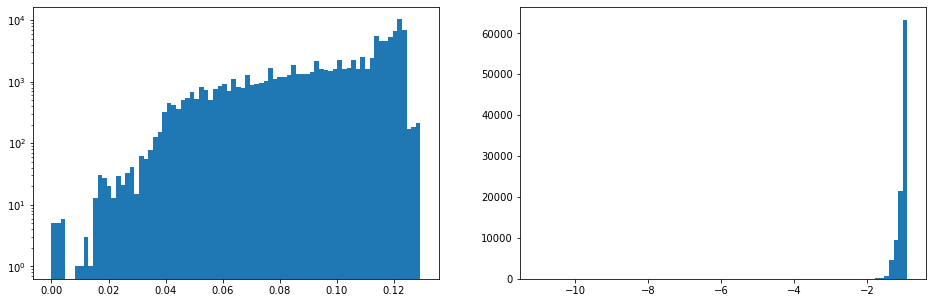

In [67]:
fig,ax = plt.subplots( 1, 2, figsize=(8*2,5))

hbins=80

final_push_weights_scaled = np.clip( final_push_weights_scaled, 1e-11, 1e11)

ax[0].hist( final_push_weights_scaled, bins=hbins)
ax[0].set_yscale('log')

ax[1].hist( np.log10(final_push_weights_scaled), bins=hbins)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

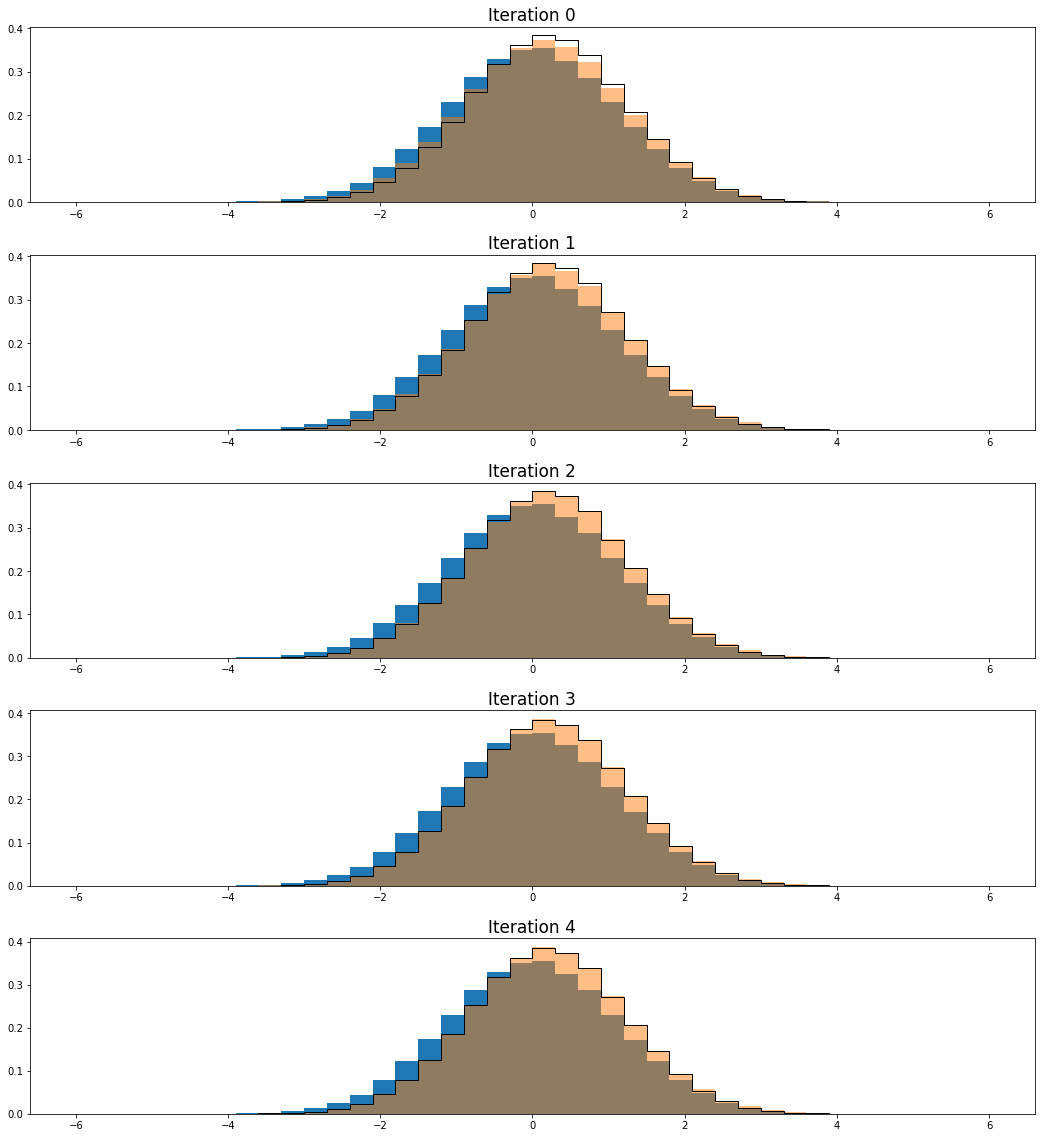

In [68]:

fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

det_hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
det_hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
            
            thisax.hist( train_det_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            det_hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_det_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :
        
        for di in range(ndim) :

            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
        
            det_hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_det_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
#    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
#    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
    
    if ndim > 1 :
        thisax = ax[ofi][0]
    else :
        thisax = ax[ofi]
    
    thisax.set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [69]:
det_hist_data_diff = det_hist_data_mc_ofweighted - det_hist_data_truth
det_hist_data_diff2 = det_hist_data_diff * det_hist_data_diff

det_hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        det_hist_data_sum_diff2[ofi,di] = np.sum( det_hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

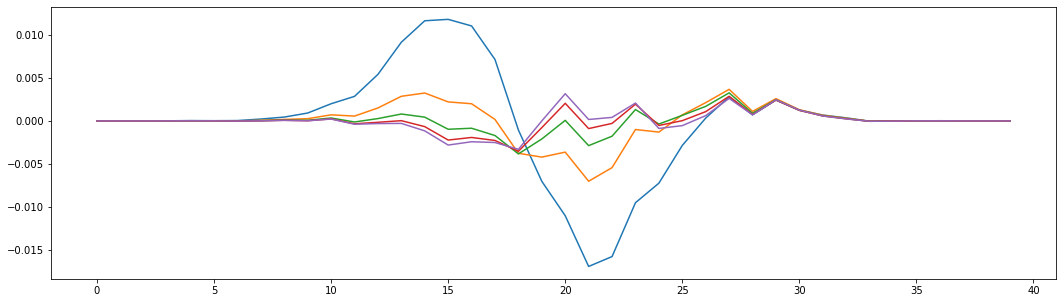

In [70]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim > 1 :
            thisax = ax[di]
        else :
            thisax = ax
        thisax.plot(det_hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

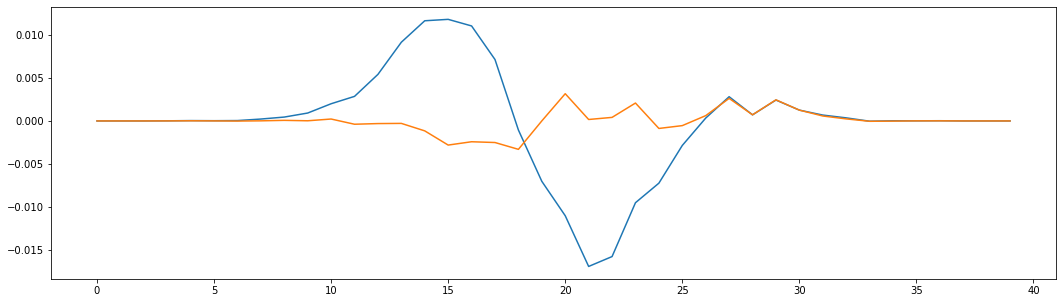

In [71]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(det_hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(det_hist_data_diff[ofi,di])

    
plt.show 

<function matplotlib.pyplot.show(close=None, block=None)>

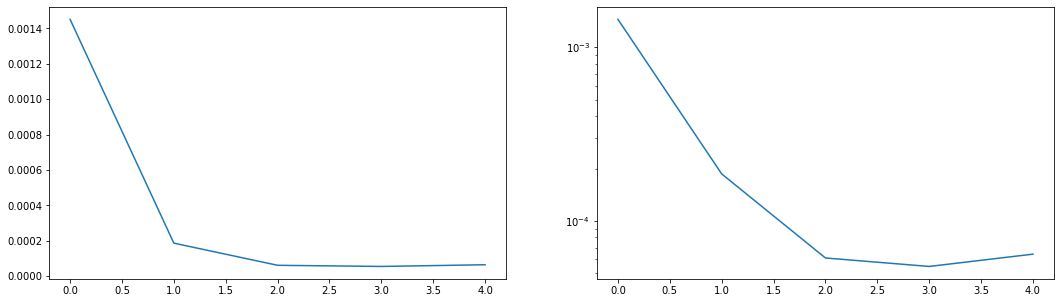

In [72]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( det_hist_data_sum_diff2)
ax[1].plot( det_hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

In [73]:
step1_mean = np.zeros( of_niter )
step1_rms = np.zeros( of_niter )

step2_mean = np.zeros( of_niter )
step2_rms = np.zeros( of_niter )

iter_val = np.zeros( of_niter )

for ofi in range( of_niter ) :
    
    iter_val[ofi] = ofi
    
    step1_mean[ofi] = np.mean( of_weights[ofi,0,:] )
    step1_rms[ofi] = np.sqrt( np.var( of_weights[ofi,0,:]))
    
    step2_mean[ofi] = np.mean( of_weights[ofi,1,:] )
    step2_rms[ofi] = np.sqrt( np.var( of_weights[ofi,1,:]))
    
    print("  iter %2d : step 1 mean  %.3f  rms %.3f      step 2 mean  %.3f  rms %.3f" % 
          (ofi, step1_mean[ofi], step1_rms[ofi], step2_mean[ofi], step2_rms[ofi]) )

  iter  0 : step 1 mean  1.000  rms 0.200      step 2 mean  0.999  rms 0.170
  iter  1 : step 1 mean  0.991  rms 0.074      step 2 mean  0.991  rms 0.057
  iter  2 : step 1 mean  0.996  rms 0.041      step 2 mean  0.996  rms 0.022
  iter  3 : step 1 mean  0.998  rms 0.034      step 2 mean  0.998  rms 0.011
  iter  4 : step 1 mean  0.999  rms 0.033      step 2 mean  0.999  rms 0.008


<function matplotlib.pyplot.show(close=None, block=None)>

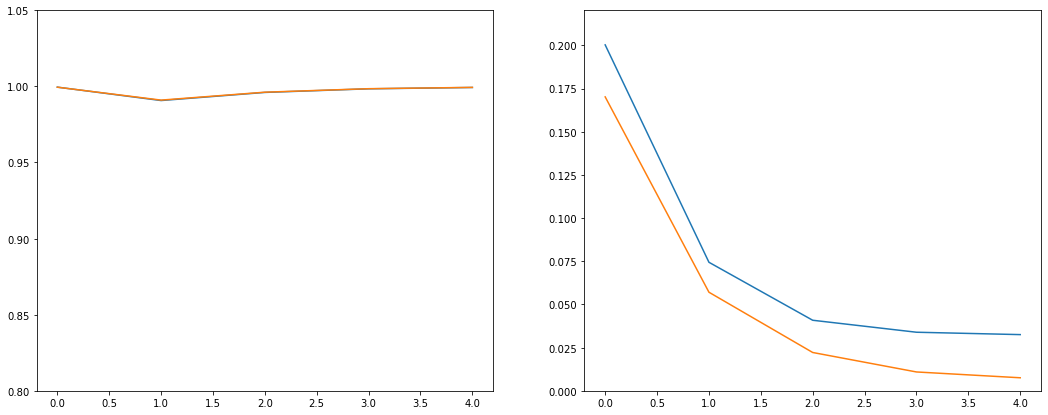

In [74]:
fig,ax = plt.subplots( 1, 2, figsize=(18,7))

ax[0].plot( iter_val, step1_mean )
ax[0].plot( iter_val, step2_mean )
ax[0].set_ylim( 0.80, 1.05)

ax[1].plot( iter_val, step1_rms )
ax[1].plot( iter_val, step2_rms )
ax[1].set_ylim( 0, 1.1*np.max(step1_rms))


plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

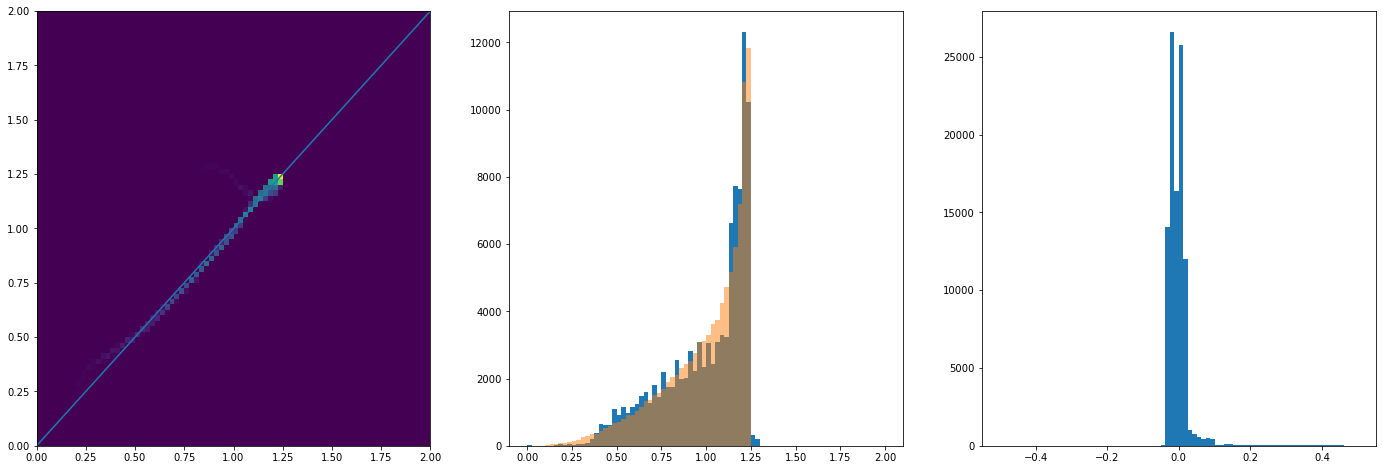

In [75]:
fig,ax = plt.subplots( 1, 3, figsize=(3*8,1*8))
max_weight = 2.0

ax[0].hist2d( calc_weight, final_push_weights, bins=[80,80], range=([0,max_weight],[0,max_weight]))
ax[0].plot([0,max_weight],[0,max_weight])

ax[1].hist( final_push_weights, bins=80, range=[0,max_weight] )
ax[1].hist( calc_weight, bins=80, range=[0,max_weight], alpha=0.5 )

ax[2].hist( final_push_weights-calc_weight, bins=80, range=[-0.5,0.5] )

plt.show

In [76]:

delta_weight_rms = np.sqrt( np.var( np.clip(final_push_weights-calc_weight,-0.5,0.5 ) ) )
print('\n\n Delta weight RMS:  %.5f\n\n' % delta_weight_rms )



 Delta weight RMS:  0.03829




In [77]:

verbose = False



import gc

In [78]:
%%time

rng = np.random.default_rng()

for bi in range(0,n_boot_samples) :
    
    if do_bootstrap :
        #print("\n Creating bootstrap sample %3d" % bi )
        #boot_true_det_pts = rng.choice( true_det_pts, size=len(true_det_pts) )
        fname = "%s/bootstrap-points-%03d.npy" % (ds_input_dir, bi)
        print('\n Reading bootstrap sample from file: %s' % fname )
        with open( fname, 'rb' ) as f :
            boot_true_det_pts = np.load(f)
        
    else :
        fname = "%s/bootstrap-points-%03d.npy" % (ds_input_dir, bi)
        print("\n Reading toy sample %3d  : %s" % (bi, fname) )
        #boot_true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)
        #boot_true_det_pts = np.random.normal( boot_true_pts, resolution )
        with open( fname, 'rb' ) as f :
            boot_true_det_pts = np.load(f)        

        
#    boot_of_return_dict = of.omnifold6b( 
#        train_both, boot_true_det_pts, of_niter, model, verbose, 
#        batch_size_setval, learning_rate_setval, epochs_setval )

#    rd = simple_pdf.simple_pdf2b( train_both, boot_true_det_pts, 
#                             train_train_det_within_sphere, train_train_gen_within_sphere,
#                             of_niter, radius, norm_radius2, False, False )

#    rd = fit_pdf_omnifold1a( train_both, boot_true_det_pts, of_niter, 0 )
    
    rd = hist_pdf_omnifold1a( train_both, boot_true_det_pts, of_niter, 0 )
    
    
    
    mc_weight_sf = (1.*len(boot_true_det_pts))/(1.*len(train_both))



    boot_final_push_weights = rd["final_push_weights"]
    boot_final_push_weights_scaled = boot_final_push_weights
    boot_final_push_weights_scaled = mc_weight_sf * boot_final_push_weights
    
    print("\n\n bootstrap %d final push weights scaled:" % bi)
    print( boot_final_push_weights_scaled )

     
    with open( '%s/bootstrap-weights-%03d.npy' % ( output_dir, bi ), 'wb' ) as f :
        np.save( f, boot_final_push_weights_scaled )
        
    del boot_final_push_weights_scaled
    del rd
    gc.collect()
    
    


 Reading toy sample   0  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-000.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94019693 1.05772649 1.0015703  ... 1.17424212 1.17408179 1.02079673]
 weights_push at the beginning
[0.92194463 1.08091828 1.00363994 ... 1.21522607 1.22377454 1.02985709]
 weights_push at the beginning
[0.91557743 1.09254643 1.00522391 ... 1.22283728 1.2395139  1.03459165]
 weights_push at the beginning
[0.91193553 1.09820568 1.0049379  ... 1.22192812 1.24490975 1.03602281]


 bootstrap 0 final push weights scaled:
[0.09088823 0.11007023 0.10032697 ... 0.12189541 0.12468228 0.10354475]

 Reading toy sample   1  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-001.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95211105 1.05984968 1.01106013 ... 1.16074991 1.15775991 1.02833271]
 weights_push at the beginning
[0.94194396 1.08690729 1.02169


 Reading toy sample  13  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-013.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95343036 1.0496606  1.00547509 ... 1.16913765 1.16195603 1.02081989]
 weights_push at the beginning
[0.9457437  1.06952072 1.01309617 ... 1.20995161 1.20557078 1.03273476]
 weights_push at the beginning
[0.94801765 1.079461   1.02005934 ... 1.21936184 1.21846603 1.04076646]
 weights_push at the beginning
[0.95165913 1.08415569 1.02471341 ... 1.22110835 1.22281461 1.0454285 ]


 bootstrap 13 final push weights scaled:
[0.09548898 0.10860454 0.10275405 ... 0.12211764 0.122475   0.10478892]

 Reading toy sample  14  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-014.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94453417 1.05390357 1.00216552 ... 1.16695984 1.16478375 1.01998474]
 weights_push at the beginning
[0.92853747 1.07578162 1.0052


 Reading toy sample  27  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-027.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94736174 1.05099026 1.00393213 ... 1.18026139 1.16908426 1.02057117]
 weights_push at the beginning
[0.93630444 1.07230016 1.01122844 ... 1.22623905 1.21446387 1.03308143]
 weights_push at the beginning
[0.93635652 1.08405716 1.01863542 ... 1.23884886 1.22740284 1.04235276]
 weights_push at the beginning
[0.93828627 1.09072624 1.0240917  ... 1.24301022 1.23105343 1.04855207]


 bootstrap 27 final push weights scaled:
[0.09400915 0.10946733 0.10279244 ... 0.12450627 0.1231853  0.10527164]

 Reading toy sample  28  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-028.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96037602 1.0594629  1.01361207 ... 1.1459183  1.14855105 1.02957264]
 weights_push at the beginning
[0.95245856 1.08464029 1.0230


 Reading toy sample  41  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-041.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94589185 1.05373114 1.00475992 ... 1.18490716 1.17514059 1.02203829]
 weights_push at the beginning
[0.93417704 1.07624505 1.01243984 ... 1.23245003 1.22343015 1.03518549]
 weights_push at the beginning
[0.93402691 1.08861612 1.0201617  ... 1.24561354 1.23808351 1.04484638]
 weights_push at the beginning
[0.93598138 1.09555851 1.02587308 ... 1.25002328 1.24299815 1.05127805]


 bootstrap 41 final push weights scaled:
[0.09379249 0.10995506 0.10298977 ... 0.12522932 0.12449257 0.10555531]

 Reading toy sample  42  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-042.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.93976342 1.04962651 0.99677088 ... 1.16694119 1.16619819 1.01474259]
 weights_push at the beginning
[0.92050278 1.06902268 0.9962


 Reading toy sample  55  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-055.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.93937885 1.05483597 1.00108332 ... 1.17549008 1.17270947 1.01982986]
 weights_push at the beginning
[0.92047491 1.07795624 1.00430146 ... 1.21993855 1.22345706 1.03002437]
 weights_push at the beginning
[0.91360754 1.09056015 1.00767778 ... 1.23100706 1.24064277 1.03669229]
 weights_push at the beginning
[0.90971781 1.09773668 1.00960121 ... 1.23332219 1.24751253 1.04052212]


 bootstrap 55 final push weights scaled:
[0.09066606 0.11020308 0.10104072 ... 0.12333774 0.12508518 0.10426156]

 Reading toy sample  56  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-056.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94554207 1.0566942  1.00592534 ... 1.17137975 1.16569624 1.02387116]
 weights_push at the beginning
[0.93058368 1.08172107 1.0129


 Reading toy sample  69  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-069.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94842261 1.0428213  1.00044913 ... 1.18184635 1.16445359 1.01549085]
 weights_push at the beginning
[0.94094571 1.06072732 1.00827014 ... 1.22709016 1.20514394 1.02725328]
 weights_push at the beginning
[0.94465146 1.07100077 1.01723317 ... 1.23900854 1.21475033 1.03711392]
 weights_push at the beginning
[0.94978813 1.07696073 1.02437216 ... 1.24283677 1.21615911 1.04424042]


 bootstrap 69 final push weights scaled:
[0.09543164 0.10805249 0.10297584 ... 0.1244868  0.12154804 0.1049347 ]

 Reading toy sample  70  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-070.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94038392 1.04689357 0.99705588 ... 1.19573889 1.18765785 1.01418695]
 weights_push at the beginning
[0.92536036 1.06368069 0.9990


 Reading toy sample  83  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-083.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.93392433 1.04238949 0.9918685  ... 1.1998887  1.18701271 1.00929262]
 weights_push at the beginning
[0.91757318 1.05834316 0.99319649 ... 1.25571887 1.24234213 1.01573866]
 weights_push at the beginning
[0.91554695 1.06669397 0.99750145 ... 1.27379893 1.26162732 1.02156263]
 weights_push at the beginning
[0.91695565 1.07094903 1.00128759 ... 1.28143505 1.26989336 1.0256315 ]


 bootstrap 83 final push weights scaled:
[0.09191112 0.10729788 0.10042201 ... 0.12859667 0.12743806 0.10283614]

 Reading toy sample  84  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-084.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95474817 1.04511875 1.00332627 ... 1.17620017 1.16710517 1.01769079]
 weights_push at the beginning
[0.94732907 1.06091719 1.0087


 Reading toy sample  97  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-097.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94239763 1.05207789 1.00022282 ... 1.17595891 1.17226747 1.01801148]
 weights_push at the beginning
[0.92755901 1.07267242 1.00336847 ... 1.21767671 1.22048555 1.02699505]
 weights_push at the beginning
[0.92445565 1.08292605 1.00657426 ... 1.22632489 1.23584627 1.03243475]
 weights_push at the beginning
[0.92367599 1.08768378 1.00790201 ... 1.22681708 1.24167686 1.03471988]


 bootstrap 97 final push weights scaled:
[0.09231144 0.10894754 0.10077118 ... 0.1225518  0.12445732 0.10349677]

 Reading toy sample  98  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-098.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94449021 1.05270804 1.0038417  ... 1.18549955 1.1729945  1.02120782]
 weights_push at the beginning
[0.9320886  1.07569995 1.0117


 Reading toy sample 109  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-109.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94499903 1.05643148 1.00596164 ... 1.17653156 1.16987834 1.02384685]
 weights_push at the beginning
[0.93137519 1.08144942 1.01411402 ... 1.22037248 1.21661195 1.03822269]
 weights_push at the beginning
[0.92935604 1.09585314 1.02207166 ... 1.23089642 1.23021296 1.04878735]
 weights_push at the beginning
[0.92985624 1.10457731 1.02810178 ... 1.23295926 1.23404906 1.05608894]


 bootstrap 109 final push weights scaled:
[0.09307701 0.11101607 0.10325593 ... 0.12330106 0.12348133 0.10612407]

 Reading toy sample 110  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-110.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94443101 1.05524088 1.00333017 ... 1.18042712 1.17605773 1.02126255]
 weights_push at the beginning
[0.93033626 1.07703679 1.007


 Reading toy sample 121  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-121.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95113117 1.05688907 1.00841177 ... 1.17625005 1.17177303 1.02536541]
 weights_push at the beginning
[0.94055693 1.07987928 1.016317   ... 1.2212425  1.22108585 1.03863542]
 weights_push at the beginning
[0.94032606 1.09150068 1.02301854 ... 1.23366512 1.23769015 1.04717077]
 weights_push at the beginning
[0.94185853 1.09722753 1.02732116 ... 1.23783757 1.24463968 1.05206468]


 bootstrap 121 final push weights scaled:
[0.0943317  0.10998471 0.10298585 ... 0.12399969 0.12484958 0.10547038]

 Reading toy sample 122  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-122.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95035562 1.05944413 1.00991758 ... 1.16352016 1.16022053 1.02745052]
 weights_push at the beginning
[0.93790041 1.08593652 1.018


 Reading toy sample 133  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-133.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.92878268 1.04251429 0.98818052 ... 1.19656966 1.18795274 1.00669953]
 weights_push at the beginning
[0.90870746 1.0579086  0.98599803 ... 1.24857164 1.24393375 1.01038193]
 weights_push at the beginning
[0.90336468 1.06542707 0.98685615 ... 1.26356038 1.26423228 1.01338659]
 weights_push at the beginning
[0.9016181  1.06865413 0.98721466 ... 1.26874382 1.27377829 1.0145891 ]


 bootstrap 133 final push weights scaled:
[0.0900747  0.106954   0.09867771 ... 0.12713159 0.12797256 0.10144621]

 Reading toy sample 134  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-134.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94689026 1.05565888 1.00492577 ... 1.16598672 1.16348671 1.02251238]
 weights_push at the beginning
[0.93388961 1.07933514 1.011


 Reading toy sample 145  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-145.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94798029 1.05393752 1.00505812 ... 1.17654691 1.17194109 1.02196788]
 weights_push at the beginning
[0.93562665 1.07570729 1.0112799  ... 1.2229696  1.22259471 1.03355806]
 weights_push at the beginning
[0.93430673 1.08672346 1.01702214 ... 1.23614221 1.2400031  1.04111805]
 weights_push at the beginning
[0.93526702 1.09221037 1.02084691 ... 1.24050199 1.24728962 1.0454888 ]


 bootstrap 145 final push weights scaled:
[0.09364961 0.10947801 0.10231898 ... 0.12424739 0.12511662 0.10478614]

 Reading toy sample 146  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-146.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.93788407 1.04180119 0.99295447 ... 1.19216643 1.17928224 1.00978994]
 weights_push at the beginning
[0.92233942 1.05721596 0.993


 Reading toy sample 157  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-157.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9533523  1.04436189 1.0018644  ... 1.16108918 1.15204324 1.01654691]
 weights_push at the beginning
[0.94437638 1.06170426 1.00681756 ... 1.20047781 1.19222384 1.02576616]
 weights_push at the beginning
[0.94487166 1.07018695 1.01147348 ... 1.20978014 1.20327448 1.03171498]
 weights_push at the beginning
[0.94669544 1.07413314 1.01422591 ... 1.21150227 1.20611677 1.03481897]


 bootstrap 157 final push weights scaled:
[0.09481904 0.10757511 0.10154895 ... 0.12113266 0.12065071 0.10361203]

 Reading toy sample 158  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-158.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.93724901 1.0452056  0.99418865 ... 1.20247205 1.19204885 1.0116393 ]
 weights_push at the beginning
[0.92180987 1.06049932 0.994


 Reading toy sample 169  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-169.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94275723 1.04700017 0.99784405 ... 1.18097795 1.17309193 1.01470782]
 weights_push at the beginning
[0.92888424 1.0649627  1.00043711 ... 1.22883803 1.22339499 1.02248653]
 weights_push at the beginning
[0.92704651 1.07368585 1.00389073 ... 1.24255299 1.24031891 1.02764889]
 weights_push at the beginning
[0.92776484 1.07761433 1.00597207 ... 1.24713873 1.24717053 1.03024064]


 bootstrap 169 final push weights scaled:
[0.09288245 0.10790175 0.10068254 ... 0.12491808 0.12506485 0.1031141 ]

 Reading toy sample 170  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-170.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95849136 1.04738033 1.00676166 ... 1.16055851 1.15144682 1.02095366]
 weights_push at the beginning
[0.95285019 1.06643529 1.014


 Reading toy sample 181  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-181.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94536769 1.05356932 1.00294924 ... 1.17882918 1.17351366 1.0204329 ]
 weights_push at the beginning
[0.93031146 1.07466414 1.00682479 ... 1.22721592 1.22531132 1.03021448]
 weights_push at the beginning
[0.92644115 1.08521317 1.01046205 ... 1.24173123 1.24329734 1.03620982]
 weights_push at the beginning
[0.92501928 1.09051881 1.01248457 ... 1.2469077  1.25069485 1.03932984]


 bootstrap 181 final push weights scaled:
[0.0924028  0.10931718 0.10133088 ... 0.12492764 0.12543081 0.10407439]

 Reading toy sample 182  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-182.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95185169 1.04344711 1.00120881 ... 1.16333634 1.15141592 1.01589267]
 weights_push at the beginning
[0.94395372 1.06151464 1.007


 Reading toy sample 193  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-193.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94762836 1.03546108 0.99211629 ... 1.1751398  1.16747461 1.00644184]
 weights_push at the beginning
[0.9354743  1.04458686 0.98930604 ... 1.22550893 1.22027206 1.00717442]
 weights_push at the beginning
[0.93376763 1.04591251 0.98746701 ... 1.24394011 1.24219039 1.00589893]
 weights_push at the beginning
[0.93382202 1.0435596  0.9845739  ... 1.25360287 1.25470937 1.00268599]


 bootstrap 193 final push weights scaled:
[0.09338086 0.10395791 0.09808514 ... 0.12605226 0.12638755 0.09983916]

 Reading toy sample 194  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-194.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94789573 1.04776815 1.00264397 ... 1.17866595 1.16776373 1.01853945]
 weights_push at the beginning
[0.93722698 1.06767236 1.009


 Reading toy sample 205  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-205.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95374959 1.05741941 1.00960905 ... 1.16312686 1.15966891 1.02635422]
 weights_push at the beginning
[0.94365616 1.08165798 1.01786946 ... 1.20232481 1.20349596 1.04025056]
 weights_push at the beginning
[0.94293705 1.09423138 1.02419716 ... 1.21152177 1.21685902 1.0488046 ]
 weights_push at the beginning
[0.94363755 1.10071802 1.02780725 ... 1.21356215 1.22150791 1.05342936]


 bootstrap 205 final push weights scaled:
[0.09441233 0.11039653 0.10294866 ... 0.12141403 0.12235183 0.10556388]

 Reading toy sample 206  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-206.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96200739 1.06296568 1.01892549 ... 1.15072487 1.14533102 1.03489636]
 weights_push at the beginning
[0.95743408 1.09302701 1.035


 Reading toy sample 217  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-217.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94838804 1.05981173 1.0095364  ... 1.16991124 1.16549234 1.02737441]
 weights_push at the beginning
[0.93512261 1.08664405 1.0188457  ... 1.21180635 1.21126229 1.04311702]
 weights_push at the beginning
[0.93255318 1.10197898 1.02700693 ... 1.2215024  1.22449674 1.05410542]
 weights_push at the beginning
[0.93225475 1.1112786  1.03292212 ... 1.22299494 1.22802128 1.06149577]


 bootstrap 217 final push weights scaled:
[0.09322925 0.11172896 0.10371522 ... 0.1222513  0.12284277 0.10666117]

 Reading toy sample 218  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-218.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94873656 1.05363878 1.0057513  ... 1.17504969 1.16777039 1.02255603]
 weights_push at the beginning
[0.93823879 1.07638554 1.013


 Reading toy sample 229  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-229.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9509667  1.05381598 1.0070285  ... 1.16317028 1.15631345 1.02352902]
 weights_push at the beginning
[0.94130406 1.07773321 1.01610376 ... 1.19828082 1.19475109 1.03799564]
 weights_push at the beginning
[0.94170753 1.09135167 1.02428944 ... 1.20332788 1.20354257 1.048273  ]
 weights_push at the beginning
[0.94355177 1.09929536 1.02993828 ... 1.20175688 1.20453928 1.05486863]


 bootstrap 229 final push weights scaled:
[0.09450903 0.11040614 0.10335926 ... 0.11992637 0.12036257 0.10590134]

 Reading toy sample 230  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-230.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94267163 1.04627358 0.99735959 ... 1.17635911 1.16820632 1.01421217]
 weights_push at the beginning
[0.92695653 1.06413169 0.998


 Reading toy sample 241  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-241.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96300149 1.05475912 1.01290306 ... 1.14355346 1.14080453 1.02760046]
 weights_push at the beginning
[0.95685579 1.0782532  1.02302205 ... 1.17613905 1.17754727 1.04246543]
 weights_push at the beginning
[0.95802673 1.09033153 1.03029586 ... 1.18244859 1.18742111 1.05146056]
 weights_push at the beginning
[0.95988964 1.09654638 1.0345839  ... 1.18276796 1.18987699 1.0564194 ]


 bootstrap 241 final push weights scaled:
[0.09612537 0.10996862 0.1036868  ... 0.11820134 0.11902312 0.10589666]

 Reading toy sample 242  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-242.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96208882 1.04850157 1.00907593 ... 1.16410716 1.15586582 1.02270577]
 weights_push at the beginning
[0.9595211  1.06698257 1.018


 Reading toy sample 253  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-253.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94155305 1.04601038 0.99641675 ... 1.17750861 1.16943219 1.01336656]
 weights_push at the beginning
[0.92617957 1.0636472  0.9977912  ... 1.22328558 1.21756257 1.02017083]
 weights_push at the beginning
[0.92274668 1.07237464 1.00018027 ... 1.23529943 1.23277882 1.02458049]
 weights_push at the beginning
[0.92189094 1.07653284 1.00136158 ... 1.23825308 1.23804762 1.02661291]


 bootstrap 253 final push weights scaled:
[0.09214422 0.10783201 0.10014634 ... 0.12386344 0.12399473 0.10271113]

 Reading toy sample 254  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-254.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94390127 1.05268293 1.00230868 ... 1.17015256 1.16465821 1.01985974]
 weights_push at the beginning
[0.92974411 1.07550166 1.007


 Reading toy sample 265  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-265.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94778274 1.05631054 1.00786732 ... 1.18206744 1.17390957 1.025133  ]
 weights_push at the beginning
[0.93698153 1.08101653 1.01800808 ... 1.23043688 1.22349009 1.04082881]
 weights_push at the beginning
[0.93782728 1.0950148  1.02794935 ... 1.24497987 1.23942049 1.05268647]
 weights_push at the beginning
[0.94116573 1.10325472 1.03589283 ... 1.25082302 1.24534703 1.06120585]


 bootstrap 265 final push weights scaled:
[0.09448481 0.11082945 0.10421714 ... 0.12545106 0.12480601 0.10674897]

 Reading toy sample 266  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-266.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95481697 1.0532666  1.00880405 ... 1.16490112 1.15624965 1.02457876]
 weights_push at the beginning
[0.94701324 1.07628052 1.018


 Reading toy sample 277  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-277.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94293995 1.04965839 0.99951912 ... 1.19186172 1.18344566 1.01671779]
 weights_push at the beginning
[0.93059233 1.06788084 1.00320011 ... 1.24181347 1.23623733 1.0253265 ]
 weights_push at the beginning
[0.93047954 1.07638762 1.00757182 ... 1.25629599 1.25443626 1.03104788]
 weights_push at the beginning
[0.93254448 1.07973782 1.0101723  ... 1.26164873 1.26250694 1.03380983]


 bootstrap 277 final push weights scaled:
[0.0934539  0.10803585 0.10112273 ... 0.12646617 0.12673504 0.10346011]

 Reading toy sample 278  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-278.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95011727 1.04833531 1.00380687 ... 1.16612967 1.1573796  1.01954273]
 weights_push at the beginning
[0.93952169 1.06921257 1.011


 Reading toy sample 289  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-289.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94701482 1.06163919 1.00929397 ... 1.16821098 1.16512554 1.02776047]
 weights_push at the beginning
[0.93354632 1.08933466 1.01823555 ... 1.20473544 1.20768406 1.043428  ]
 weights_push at the beginning
[0.93081848 1.10516793 1.02576938 ... 1.20956426 1.21818753 1.05402077]
 weights_push at the beginning
[0.9300738  1.11458477 1.03065952 ... 1.20702444 1.21967306 1.06060754]


 bootstrap 289 final push weights scaled:
[0.09294027 0.11204267 0.10335526 ... 0.12032085 0.12186062 0.10646071]

 Reading toy sample 290  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-290.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95008739 1.05968285 1.01019092 ... 1.15935615 1.15758029 1.02774496]
 weights_push at the beginning
[0.93835797 1.08703745 1.020


 Reading toy sample 301  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-301.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94383346 1.04398848 0.99730348 ... 1.18661236 1.17677365 1.01330607]
 weights_push at the beginning
[0.93245241 1.06015123 1.00084237 ... 1.23675503 1.22840767 1.02114045]
 weights_push at the beginning
[0.93310137 1.06763412 1.0055197  ... 1.25269308 1.24696741 1.02674069]
 weights_push at the beginning
[0.9359239  1.07045256 1.00867167 ... 1.25986031 1.25593199 1.02971179]


 bootstrap 301 final push weights scaled:
[0.09387124 0.10707826 0.10104069 ... 0.12647945 0.12618704 0.10308781]

 Reading toy sample 302  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-302.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9400764  1.04930201 0.9975683  ... 1.17017177 1.1649533  1.01544969]
 weights_push at the beginning
[0.92293717 1.06948773 0.999


 Reading toy sample 313  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-313.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94096486 1.05273458 1.00121714 ... 1.1717084  1.16635099 1.0191928 ]
 weights_push at the beginning
[0.92670231 1.07611291 1.00731323 ... 1.20761251 1.20833355 1.03137304]
 weights_push at the beginning
[0.92445605 1.08960292 1.01372615 ... 1.21168474 1.21894813 1.04030913]
 weights_push at the beginning
[0.924431   1.0974194  1.01801369 ... 1.20884193 1.22124696 1.04583997]


 bootstrap 313 final push weights scaled:
[0.09244823 0.11019425 0.10204544 ... 0.12051526 0.12214705 0.10489807]

 Reading toy sample 314  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-314.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94347217 1.05330914 1.00309057 ... 1.19214404 1.18291711 1.02062282]
 weights_push at the beginning
[0.93114859 1.07494443 1.009


 Reading toy sample 325  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-325.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94684134 1.04529061 1.00055612 ... 1.17108916 1.15887868 1.01631634]
 weights_push at the beginning
[0.93698887 1.06483575 1.00751148 ... 1.20893556 1.19692484 1.02793957]
 weights_push at the beginning
[0.93812028 1.07616375 1.01518352 ... 1.2154751  1.2052415  1.03717067]
 weights_push at the beginning
[0.94075184 1.08278985 1.02087721 ... 1.2150408  1.20598336 1.04343165]


 bootstrap 325 final push weights scaled:
[0.09429526 0.10867529 0.10247925 ... 0.12135082 0.12049655 0.10475659]

 Reading toy sample 326  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-326.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9517974  1.05517964 1.00868261 ... 1.15717389 1.15241756 1.02519327]
 weights_push at the beginning
[0.94127446 1.08048096 1.018


 Reading toy sample 337  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-337.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95060304 1.0527274  1.00661871 ... 1.16487698 1.1564844  1.02302636]
 weights_push at the beginning
[0.93915619 1.07616902 1.0149295  ... 1.20514229 1.1976527  1.03698759]
 weights_push at the beginning
[0.93766851 1.08964716 1.02253294 ... 1.21462848 1.20849893 1.04701505]
 weights_push at the beginning
[0.9378977  1.09788796 1.02802627 ... 1.21646937 1.21070519 1.05380955]


 bootstrap 337 final push weights scaled:
[0.0938099  0.11033196 0.10319026 ... 0.12165349 0.12103205 0.10585411]

 Reading toy sample 338  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-338.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.93329696 1.04529631 0.9924996  ... 1.20038634 1.18943864 1.01057981]
 weights_push at the beginning
[0.91616505 1.0619893  0.993


 Reading toy sample 349  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-349.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.92560559 1.04243044 0.98510103 ... 1.2078532  1.20190726 1.00421916]
 weights_push at the beginning
[0.90125866 1.05479703 0.97791482 ... 1.27192367 1.27065956 1.00316569]
 weights_push at the beginning
[0.89233436 1.05878628 0.97407661 ... 1.29588781 1.30010266 1.00152158]
 weights_push at the beginning
[0.88787534 1.05884822 0.97054977 ... 1.3074942  1.31611657 0.99878518]


 bootstrap 349 final push weights scaled:
[0.08849575 0.10570725 0.09669656 ... 0.13146292 0.13266647 0.09954186]

 Reading toy sample 350  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-350.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95037693 1.05561376 1.00856984 ... 1.16673869 1.15667615 1.02537484]
 weights_push at the beginning
[0.94236712 1.08162669 1.020


 Reading toy sample 361  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-361.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94986161 1.05920944 1.00866238 ... 1.16587163 1.16504142 1.02627619]
 weights_push at the beginning
[0.93649721 1.08423368 1.01572145 ... 1.20639843 1.21239025 1.03958661]
 weights_push at the beginning
[0.93325436 1.09733124 1.02114945 ... 1.21564736 1.22771727 1.04768011]
 weights_push at the beginning
[0.9320552  1.10430422 1.02421352 ... 1.21697478 1.23339386 1.05207739]


 bootstrap 361 final push weights scaled:
[0.09311172 0.11080405 0.10256315 ... 0.12164024 0.12358831 0.10542564]

 Reading toy sample 362  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-362.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94547037 1.04525057 0.99941402 ... 1.17986964 1.170698   1.01540832]
 weights_push at the beginning
[0.93307946 1.0629837  1.003


 Reading toy sample 373  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-373.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94203382 1.05971273 1.00582441 ... 1.18906055 1.18500542 1.02473192]
 weights_push at the beginning
[0.92704293 1.08464001 1.01281957 ... 1.23833897 1.23965393 1.0381664 ]
 weights_push at the beginning
[0.9244706  1.09801278 1.01958186 ... 1.25221889 1.25866819 1.04745682]
 weights_push at the beginning
[0.92468633 1.10525294 1.02435808 ... 1.25693151 1.26685567 1.05330205]


 bootstrap 373 final push weights scaled:
[0.09254032 0.11091447 0.10275387 ... 0.12593728 0.12714504 0.1056922 ]

 Reading toy sample 374  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-374.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9484985  1.05264432 1.00461064 ... 1.16585599 1.16016172 1.02140294]
 weights_push at the beginning
[0.93635381 1.07495015 1.011


 Reading toy sample 385  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-385.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94047593 1.04938247 0.99980254 ... 1.19117221 1.17825332 1.01725071]
 weights_push at the beginning
[0.92736634 1.06994406 1.00585943 ... 1.23803078 1.22478593 1.02867378]
 weights_push at the beginning
[0.92691313 1.08175658 1.01326532 ... 1.24919433 1.23723831 1.03796518]
 weights_push at the beginning
[0.92873306 1.08869005 1.01904181 ... 1.2514371  1.24014991 1.04447091]


 bootstrap 385 final push weights scaled:
[0.09305127 0.10929059 0.10232413 ... 0.12516014 0.12403157 0.10489726]

 Reading toy sample 386  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-386.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94738431 1.06764656 1.01244323 ... 1.16869005 1.16809844 1.03193599]
 weights_push at the beginning
[0.9322753  1.09799892 1.021


 Reading toy sample 397  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-397.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95210292 1.05091648 1.00523712 ... 1.16879384 1.1615491  1.02115564]
 weights_push at the beginning
[0.94226187 1.07152058 1.01182196 ... 1.21166926 1.20636616 1.03266919]
 weights_push at the beginning
[0.94237205 1.08196288 1.01763225 ... 1.2231475  1.22020019 1.04014122]
 weights_push at the beginning
[0.94408316 1.08716149 1.02128921 ... 1.22663604 1.22504836 1.04435525]


 bootstrap 397 final push weights scaled:
[0.09456227 0.10896139 0.10233053 ... 0.12281257 0.12270986 0.10465187]

 Reading toy sample 398  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-398.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94443883 1.05880003 1.00654506 ... 1.1748835  1.16753179 1.02505601]
 weights_push at the beginning
[0.93018234 1.08521293 1.014


 Reading toy sample 409  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-409.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.93324346 1.04406768 0.99193875 ... 1.18356423 1.17071575 1.01003123]
 weights_push at the beginning
[0.91481281 1.0624561  0.99266872 ... 1.22581202 1.21339837 1.01694545]
 weights_push at the beginning
[0.90971089 1.07336404 0.99579621 ... 1.23283949 1.22283387 1.02285993]
 weights_push at the beginning
[0.9074039  1.08012838 0.99800366 ... 1.23096883 1.22291892 1.02672101]


 bootstrap 409 final push weights scaled:
[0.09054748 0.10845961 0.09991186 ... 0.12269605 0.12202656 0.10290525]

 Reading toy sample 410  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-410.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95253021 1.04681611 1.00321696 ... 1.16643381 1.15706089 1.01839675]
 weights_push at the beginning
[0.94275561 1.06548855 1.008


 Reading toy sample 421  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-421.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94726598 1.04298207 0.99884512 ... 1.17238517 1.16116428 1.01426122]
 weights_push at the beginning
[0.93634987 1.06033416 1.00354582 ... 1.21679763 1.20528465 1.02352985]
 weights_push at the beginning
[0.93629839 1.069469   1.00899881 ... 1.22948583 1.21893889 1.03045361]
 weights_push at the beginning
[0.93806955 1.07421069 1.01287461 ... 1.23423369 1.22402372 1.03479965]


 bootstrap 421 final push weights scaled:
[0.09397159 0.10766106 0.10153544 ... 0.12370676 0.1226558  0.10373992]

 Reading toy sample 422  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-422.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94158089 1.04894354 0.99961935 ... 1.17876817 1.16760604 1.01691444]
 weights_push at the beginning
[0.92870341 1.07028691 1.005


 Reading toy sample 433  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-433.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94348474 1.0554403  1.00308053 ... 1.17158813 1.16956936 1.02112815]
 weights_push at the beginning
[0.92864795 1.07865193 1.00810149 ... 1.21143751 1.21677753 1.03231807]
 weights_push at the beginning
[0.92546417 1.09090723 1.0128031  ... 1.21866336 1.23114615 1.03949769]
 weights_push at the beginning
[0.92481345 1.09732973 1.01553742 ... 1.21782831 1.23585586 1.04334225]


 bootstrap 433 final push weights scaled:
[0.09245923 0.11005522 0.10167133 ... 0.12152428 0.12375429 0.10450353]

 Reading toy sample 434  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-434.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95205429 1.0585082  1.01006516 ... 1.16726432 1.16253049 1.02718169]
 weights_push at the beginning
[0.94154114 1.08393966 1.019


 Reading toy sample 445  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-445.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94172154 1.04748044 0.99789687 ... 1.1683635  1.16122915 1.01502631]
 weights_push at the beginning
[0.92739389 1.06756949 1.00145184 ... 1.20465493 1.20191851 1.02424583]
 weights_push at the beginning
[0.92462679 1.0786631  1.00561861 ... 1.209693   1.21217492 1.03073512]
 weights_push at the beginning
[0.92389424 1.08471491 1.00794543 ... 1.20771469 1.2143016  1.03423795]


 bootstrap 445 final push weights scaled:
[0.09231582 0.10879325 0.10086704 ... 0.12046362 0.12142998 0.10356824]

 Reading toy sample 446  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-446.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.93018633 1.03204919 0.98259986 ... 1.1934233  1.17891947 0.99925608]
 weights_push at the beginning
[0.91066521 1.04180282 0.977


 Reading toy sample 457  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-457.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94051652 1.05599586 1.00248641 ... 1.18673615 1.18155047 1.02111395]
 weights_push at the beginning
[0.92383533 1.07872812 1.00696396 ... 1.23602566 1.23510113 1.03200164]
 weights_push at the beginning
[0.91964314 1.09073969 1.01175364 ... 1.24976634 1.25315249 1.03940525]
 weights_push at the beginning
[0.91843964 1.09724331 1.0150454  ... 1.25384523 1.26012667 1.04391414]


 bootstrap 457 final push weights scaled:
[0.09179422 0.11008409 0.10171224 ... 0.1255167  0.12632033 0.10466119]

 Reading toy sample 458  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-458.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95266212 1.0494308  1.00511181 ... 1.17212881 1.16307112 1.02057731]
 weights_push at the beginning
[0.94399492 1.06907771 1.012


 Reading toy sample 469  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-469.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94058615 1.03715006 0.99160873 ... 1.18211428 1.170511   1.00709098]
 weights_push at the beginning
[0.92611142 1.05023319 0.99172357 ... 1.23308213 1.22126172 1.01152945]
 weights_push at the beginning
[0.92399425 1.05625517 0.99412967 ... 1.25006328 1.23959054 1.01507844]
 weights_push at the beginning
[0.92458709 1.0586564  0.99593384 ... 1.25772592 1.24811514 1.0169887 ]


 bootstrap 469 final push weights scaled:
[0.09256496 0.10592285 0.09969961 ... 0.1262583  0.12532593 0.10177814]

 Reading toy sample 470  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-470.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95289347 1.06144601 1.01202232 ... 1.16091204 1.15759976 1.02938594]
 weights_push at the beginning
[0.9436136  1.08930295 1.023


 Reading toy sample 481  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-481.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.93277763 1.04340305 0.99184074 ... 1.19764816 1.18194613 1.00972795]
 weights_push at the beginning
[0.91677227 1.0609138  0.9939001  ... 1.24655987 1.22925031 1.01725686]
 weights_push at the beginning
[0.91491135 1.07103671 0.9988113  ... 1.25819463 1.24156689 1.02412645]
 weights_push at the beginning
[0.91586628 1.07690424 1.00271557 ... 1.26032501 1.24402758 1.02884364]


 bootstrap 481 final push weights scaled:
[0.09169904 0.10803551 0.10053178 ... 0.12601116 0.12435948 0.10318469]

 Reading toy sample 482  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-482.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95814827 1.0515285  1.00985277 ... 1.16162221 1.151609   1.02467144]
 weights_push at the beginning
[0.95194561 1.073857   1.020


 Reading toy sample 493  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-493.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94197869 1.05817041 1.00492802 ... 1.18451443 1.17537308 1.02372243]
 weights_push at the beginning
[0.92848379 1.0839166  1.01290865 ... 1.22680154 1.21975693 1.03815878]
 weights_push at the beginning
[0.92733919 1.09902651 1.02098092 ... 1.23417134 1.22994141 1.04894808]
 weights_push at the beginning
[0.92855382 1.10824023 1.02686836 ... 1.23304503 1.23051051 1.05621538]


 bootstrap 493 final push weights scaled:
[0.0929847  0.11141063 0.10308567 ... 0.12301563 0.12283606 0.10610349]

 Reading toy sample 494  : bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-points-494.npy
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95447816 1.0594331  1.01215123 ... 1.16130215 1.15830925 1.02891825]
 weights_push at the beginning
[0.94407892 1.08551627 1.022

In [79]:
print('\n\n Done\n\n')



 Done


